# Analytics - Product Quality - GitHub

#### Date: 2020/02

#### SUMMARY:

- This notebook represents the project quality analysis of the date exposed right above. 

### TEAM:

##### Semester: YYYY/0X
##### Professor: Hilmer Neri

##### Members:

- Member x
- Member y


### LIBRARIES

In [1]:
# Deal with data
import pandas as pd
import json
from glob import glob
import os

# Deal with visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Deal with type hints
from typing import List

# Deal with time
import datetime

### GRAPH SETTINGS

In [2]:
%config InlineBackend.figure_format ='retina'
sns.set(font_scale=1.5)
sns.set_style('darkgrid',
              {'xtick.bottom' : True,
               'ytick.left': True,
               'grid.linestyle':'--',
               'font.monospace': ['Computer Modern Typewriter'],
               'axes.edgecolor' : 'white'})

### DATAFRAME SETTINGS

In [3]:
pd.set_option("display.max_rows", None, "display.max_columns", None)

#### Replace your repository names

In [4]:
# Add your repos here
# Example: ['YourRepoName_1', 'YourRepoName_2']
repos_project = ['Admin']

### GitHub
##### Path to the folder with all your jsons

In [7]:
data_runs = glob('./analytics-raw-data/GitHub_API-Runs-fga-eps-mds-*.json')

# Create Workflow Runs DataFrame

#### Unmarshall json

In [8]:
def unmarshall(json_path: str) -> dict:
    with open(json_path) as json_file:
        json_obj = json.load(json_file)
    return json_obj

#### Extract Workflow Runs Data

In [9]:
def get_workflow_data():
    for json_path in data_runs:
        dados = unmarshall(json_path)
        table_data = []
        for run in dados["workflow_runs"]:
            updated_at = datetime.datetime.strptime(run["updated_at"], "%Y-%m-%dT%H:%M:%SZ")
            created_at = datetime.datetime.strptime(run["created_at"], "%Y-%m-%dT%H:%M:%SZ")
            feedback_time = (updated_at - created_at).total_seconds()
            
            workflow_id = run["id"]
            conclusion = run["conclusion"]
            author = run["actor"]["login"]

            repo = run["repository"]["name"].split("-")[-1]
            
            table_data.append({
                "Workflow_run ID": workflow_id,
                "Conclusion": conclusion,
                "Author": author,
                "Created at": created_at,
                "Updated at": updated_at,
                "Feedback Time": feedback_time,
                "Repository Name": repo
            })

    return table_data

#### Generate Workflow Runs DataFrame

In [10]:
def generate_workflow_runs_df(data: List[dict]) -> pd.DataFrame:
    df = pd.DataFrame(data)

    return df

In [11]:
workflow_run_df = generate_workflow_runs_df(get_workflow_data())
workflow_run_df.head()

,Workflow_run ID,Conclusion,Author,Created at,Updated at,Feedback Time,Workflow .YML Name,Repository Name
0,10712048238,failure,victorleaoo,2024-09-05 01:10:01,2024-09-05 01:11:25,84.0,code-analysis,Admin
1,10712041253,success,victorleaoo,2024-09-05 01:09:17,2024-09-05 01:10:47,90.0,code-analysis,Admin
2,10712038868,success,victorleaoo,2024-09-05 01:09:04,2024-09-05 01:10:26,82.0,code-analysis,Admin
3,10712038863,success,victorleaoo,2024-09-05 01:09:04,2024-09-05 01:09:15,11.0,deploy,Admin
4,10711995645,success,victorleaoo,2024-09-05 01:04:39,2024-09-05 01:04:50,11.0,deploy,Admin


### Create dataframe per repository

In [13]:
repos_dataframes = []

for repo in repos_project:
    dataframe = workflow_run_df[workflow_run_df['Repository Name'] == repo]
    repos_dataframes.append({'name': repo, 'df': dataframe})

## Quality Aspect - Productivity

### Factor - Testing Performance

#### CI Feedback Time

In [16]:
def ci_feedback_time(df: pd.DataFrame):
    feedback_times = []
    authors_feedback_times = {}
    ci_feedback_times = []

    # Filter for builds workflow runs only
    df_filtered = df.copy()

    for run in df_filtered.index:
        updated_at = df["Updated at"][run]
        created_at = df["Created at"][run]
        feedback_time = (updated_at - created_at).total_seconds()
        feedback_times.append(feedback_time)

    ci_feedback_time = sum(feedback_times) / len(feedback_times)
    df_filtered.loc[:, "Ci Feedback Time"] = ci_feedback_time

    return df_filtered

#### Extra: Count of Successes and Failures Workflows

In [17]:
def count_success_failure_workflow_runs(df: pd.DataFrame):
    counts = df['Conclusion'].value_counts()

    num_failures = counts.get('failure', 0)
    num_successes = counts.get('success', 0)

    return num_failures, num_successes

### Factor - Issues' Velocity

#### Team Throughput

## Calculate measures for each repository

Filter the dataset with the set dates in the notebook's beginning.

In [18]:
def create_metrics_df() -> pd.DataFrame:

    m1_list = []
    m2_list = []
    m3_list = []

    repository_list = []
    version_list = []

    for repo_info in repos_dataframes:
        repo_df = repo_info["df"]

        repo_df['Updated at'] = pd.to_datetime(repo_df['Updated at'])

        # Filter the selected date range
        df_date_filtered = repo_df.copy()

        try:
            m1_list.append(ci_feedback_time(df_date_filtered))
        except Exception:
            m1_list.append(0)

        try:
            m2_list.append(count_success_failure_workflow_runs(df_date_filtered))
        except Exception:
            m2_list.append(0)

        try:
            m3_list.append(duplication(version_df))
        except Exception:
            m3_list.append(0)

        repository_list.append(repo_info['name'])

    return m1_list, m2_list, m3_list, repository_list

In [19]:
m1_list, m2_list, m3_list, repository_list = create_metrics_df()

## Plotting Metrics Functions

### Generate CI Feedback Time Plots

In [20]:
def ci_feedback_time_plots(df: pd.DataFrame, repo_name: str):
    temp = df[['Created at', 'Ci Feedback Time']]
    dates = temp.groupby(['Created at']).mean().reset_index()
    dates['Created at'] = pd.to_datetime(dates['Created at'])

    plt.figure(figsize=(15, 7))
    plt.plot(range(len(dates)), dates['Ci Feedback Time'], marker='o', color='b', label='Feedback Time')
    plt.xlabel("Created at")
    plt.ylabel("CI FeedBack Time")
    plt.title(f"CI FeedBack Time By Creation Date - {repo_name}")
    plt.xticks(range(len(dates)), dates['Created at'].dt.strftime('%Y-%m-%d'), rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

### Generate Count of Successes and Failures Workflows Plots

In [21]:
def count_sucess_failure_workflow_plot(data: list, repo_name: str):
    labels = ["Success", "Failure"]
    sizes = [data[1], data[0]]
    plt.figure(figsize=(15, 7))
    colors = ['lightgreen', 'crimson']
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
    plt.title(f"Quantidade de Workflows_runs com Sucesso e Falha - {repo_name}")
    plt.legend(labels, loc='best')
    plt.tight_layout()
    plt.show()

## Data Visualization

In this area you will need to plot the metrics of each repository in the selected date range.

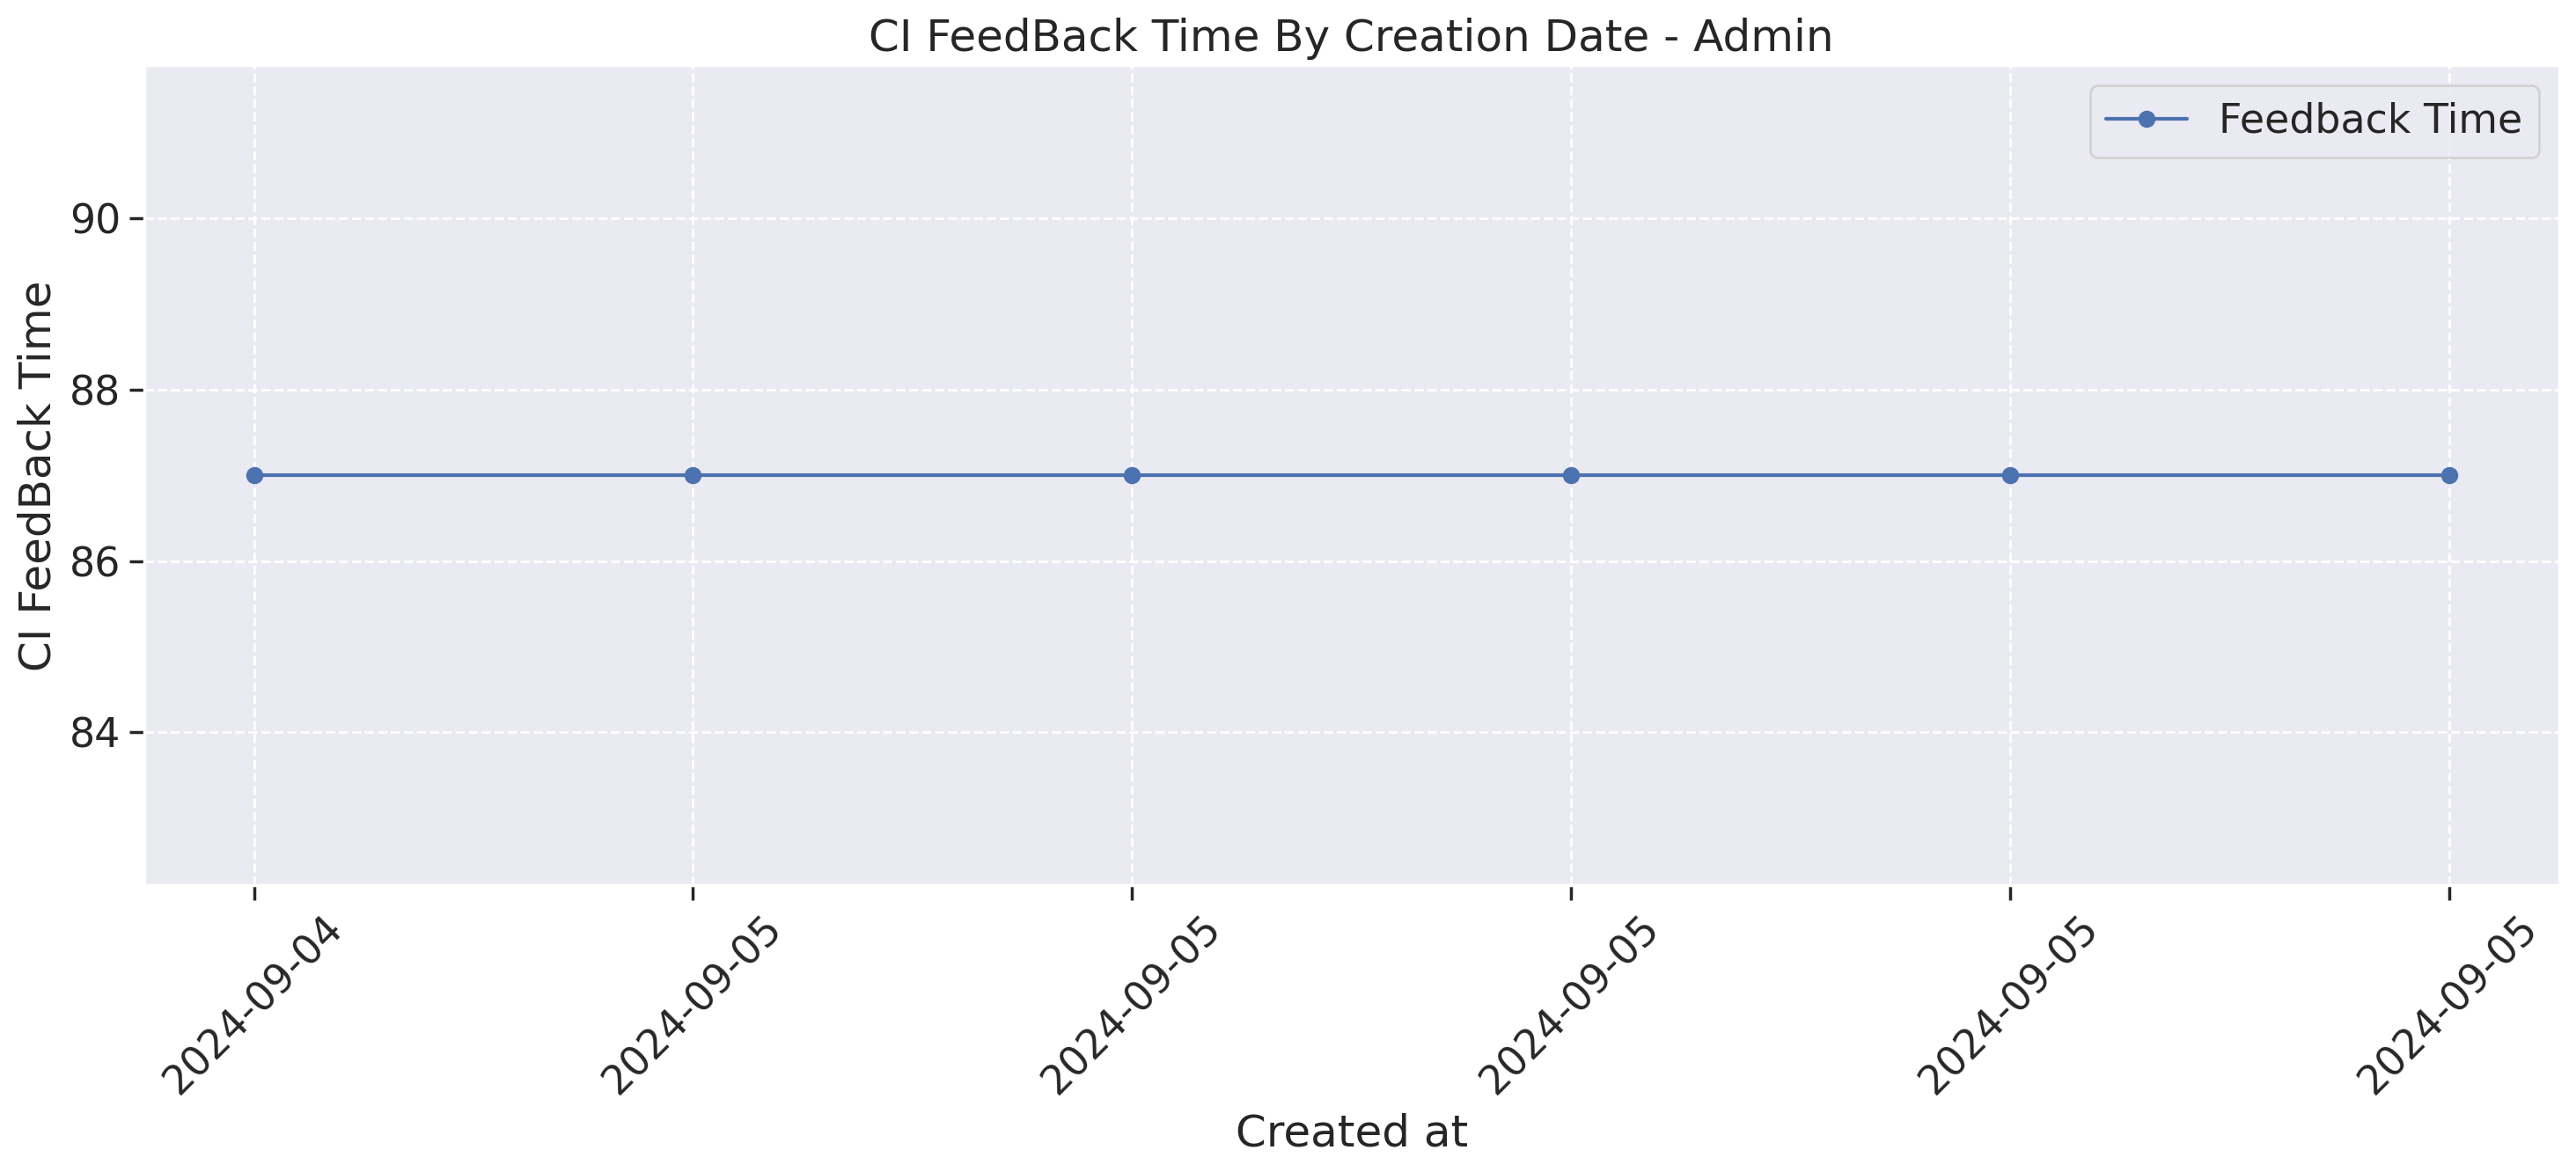

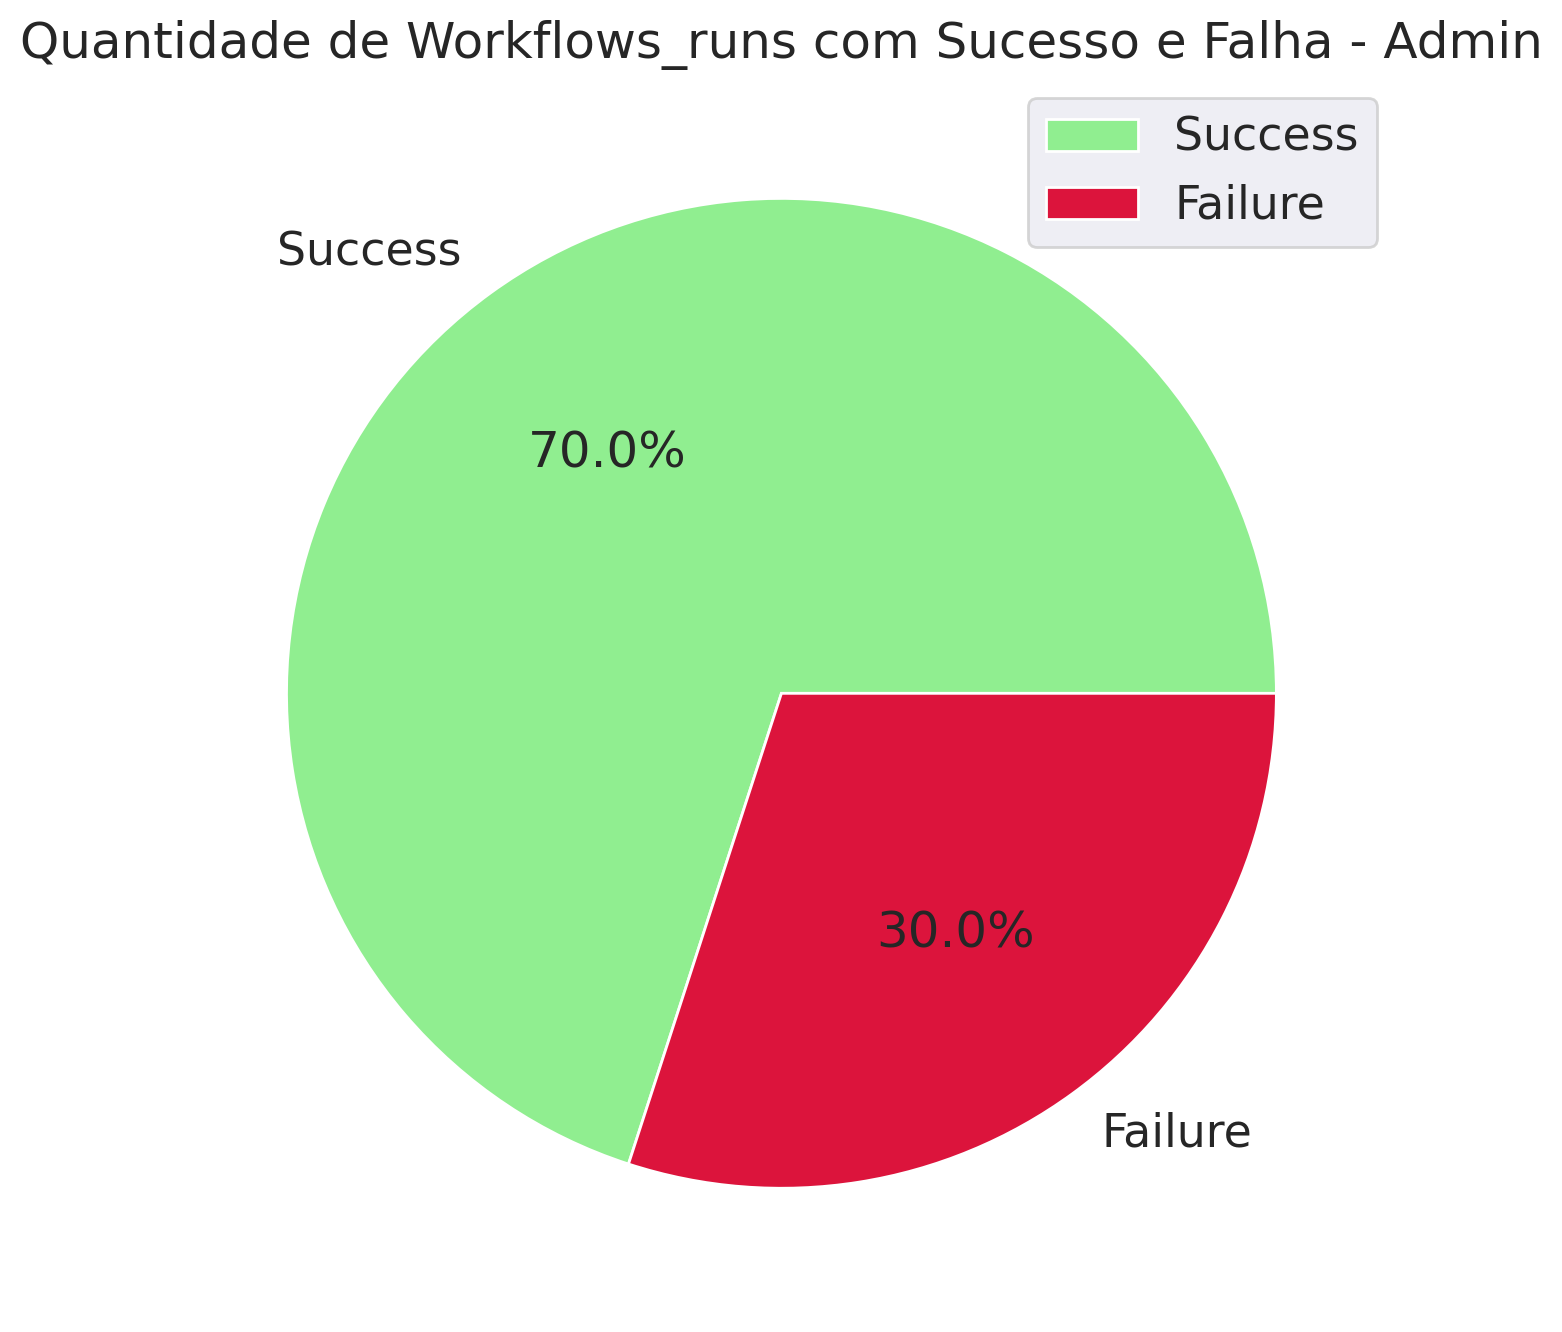

In [22]:
for repo in range(len(repository_list)):
    ci_feedback_time_plots(m1_list[repo], repository_list[repo])
    count_sucess_failure_workflow_plot(m2_list[repo], repository_list[repo])